In [229]:
import pandas as pd
import warnings
import requests
import re
import json

warnings.filterwarnings("ignore")

## Step 1: Import Raw Eurovision Data
Download raw data from https://github.com/Spijkervet/eurovision-dataset/releases
* contestants.csvv*  votes.csv

Import into Pandas Dataframes



In [2]:
contestants_raw = pd.read_csv("data/spijkervet/contestants.csv")
contestants_raw

,year,to_country_id,to_country,performer,song,place_contest,sf_num,running_final,running_sf,place_final,...,place_sf,points_sf,points_tele_final,points_jury_final,points_tele_sf,points_jury_sf,composers,lyricists,lyrics,youtube_url
0,1956,ch,Switzerland,Lys Assia,Refrain,2.0,NaN,2.0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Georg Benz Stahl,NaN,"(Refrain d'amour...)\n\nRefrain, couleur du ci...",https://youtube.com/watch?v=IyqIPvOkiRk
1,1956,nl,Netherlands,Jetty Paerl,De Vogels Van Holland,2.0,NaN,1.0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Cor Lemaire,Annie M. G. Schmidt,De vogels van Holland zijn zo muzikaal\nZe ler...,https://youtube.com/watch?v=u45UQVGRVPA
2,1956,be,Belgium,Fud Leclerc,Messieurs Les Noyés De La Seine,2.0,NaN,3.0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Jacques Say;Jean Miret,Robert Montal,Messieurs les noyés de la Seine\nOuvrez-moi le...,https://youtube.com/watch?v=U9O3sqlyra0
3,1956,de,Germany,Walter Andreas Schwarz,Im Wartesaal Zum Großen Glück,2.0,NaN,4.0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Walter Andreas Schwarz,NaN,"Es gibt einen Hafen, da fährt kaum ein Schiff\...",https://youtube.com/watch?v=BDNARIDnmTc
4,1956,fr,France,Mathé Altéry,Le Temps Perdu,2.0,NaN,5.0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,André Lodge,Rachèle Thoreau,"Chante, carillon\nLe chant du temps perdu\nCha...",https://youtube.com/watch?v=dm1L0XyikKI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1598,2020,fi,Finland,Aksel Kankaanranta,Looking Back,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,We would fall asleep\nTalking 'bout our dreams...,https://youtube.com/watch?v=EgONBKFQpxE
1599,2020,ge,Georgia,Tornike Kipiani,Take Me As I Am,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,How do you want me to talk like an Englishman?...,https://youtube.com/watch?v=LjNK4Xywjc4
1600,2020,lv,Latvia,Samanta Tīna,Still Breathing,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I will keep on going\nI will keep on running\n...,https://youtube.com/watch?v=ELr6U2fOrnE
1601,2020,pt,Portugal,Elisa,Medo de sentir,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Qual é a saída\nEu acho que já não sei amar\nE...,https://youtube.com/watch?v=eIZ48w4epng


In [3]:
votes_raw = pd.read_csv("data/spijkervet/votes.csv")
votes_raw

,year,round,from_country_id,to_country_id,from_country,to_country,total_points,tele_points,jury_points
0,1957,final,at,nl,at,nl,6,NaN,NaN
1,1957,final,at,fr,at,fr,0,NaN,NaN
2,1957,final,at,dk,at,dk,0,NaN,NaN
3,1957,final,at,lu,at,lu,3,NaN,NaN
4,1957,final,at,de,at,de,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
47002,2019,semi-final-2,gb,hr,gb,hr,8,0.0,8.0
47003,2019,semi-final-2,gb,lv,gb,lv,0,0.0,0.0
47004,2019,semi-final-2,gb,am,gb,am,0,0.0,0.0
47005,2019,semi-final-2,gb,at,gb,at,0,0.0,0.0


## Step 2: Check Raw Data

### 2.1 Country ID Mappings
Voting data from votes.csv has country ids rather than country names (e.g. country id = ie for  Ireland)

Mappings from country id to country can be found in the contestants.csv

We should check that all the country ids in votes.csv has a mapping from contestants.csv

In [4]:
# get counties id map by selecting columns from contentants dataframe
country_ids_map = contestants_raw[["to_country_id", "to_country"]]

# we can drop repeating rows...
country_ids_map.drop_duplicates(inplace=True)

country_ids_map

,to_country_id,to_country
0,ch,Switzerland
1,nl,Netherlands
2,be,Belgium
3,de,Germany
4,fr,France
...,...,...
1504,Romania,Romania
1507,Azerbaijan,Azerbaijan
1513,Russia,Russia
1568,Australia,Australia


In [5]:
# It apperas Countries are included twice here...
country_ids_map[country_ids_map["to_country"] == "Ireland"]

,to_country_id,to_country
125,ie,Ireland
979,Ireland,Ireland


In [6]:
# Keep the rows in country_ids_map for ids that have 2 letters... (so keep row with 'ie' inst

# calculate lengh of values in to_country_id colummn
country_ids_map["id_character_count"] = country_ids_map["to_country_id"].str.len()
# filter for values that hvae to_country_id of lengh 2
country_ids_map = country_ids_map[country_ids_map["id_character_count"]==2]

# remove the new column
country_ids_map = country_ids_map[["to_country_id", "to_country"]]
country_ids_map

,to_country_id,to_country
0,ch,Switzerland
1,nl,Netherlands
2,be,Belgium
3,de,Germany
4,fr,France
5,lu,Luxembourg
6,it,Italy
14,dk,Denmark
18,gb,United Kingdom
21,at,Austria


In [7]:
# check that this filter hasn't inadvertently removed any countries...
countries_raw = contestants_raw["to_country"].unique().tolist()

# get countries that are not in country_ids_map
[i for i in countries_raw if i not in country_ids_map["to_country"].tolist()]

['Andorra']

In [8]:
# check that all codes in votes.csv appear in country_ids_map
countries_ids_raw = votes_raw["from_country_id"].unique().tolist()

# get countries that are not in country_ids_map
[i for i in countries_ids_raw if i not in country_ids_map["to_country_id"].tolist()]


['ad']

In [9]:
# We should add 'ad' -> 'Andorra' to our country_ids_map dataframe
country_ids_map = pd.concat([
    country_ids_map, 
    pd.DataFrame({"to_country_id": ["ad"], "to_country": ["Andorra"]})
])

# sort dataframe to make it more readable. Reset the rows numbers too. 
country_ids_map.sort_values(by="to_country_id", inplace=True)
country_ids_map.reset_index(inplace=True, drop=True)
                            



In [10]:
country_ids_map.rename(columns={"to_country_id": "country_id", "to_country": "country"}, inplace=True)

## Step 3: For each Paricipant Song, scrape Youtube Views

youtube webaddresses (urls) are provided with the contestants.csv dataset.

Use these urls to 'scrape' View Count from each YouTube page...
- use requests to get youtube webpage data
- use regex to find viewCount within the webpage data

In [13]:
# This is based on instuctions from 
# https://towardsdatascience.com/web-scraping-regular-expressions-and-data-visualization-doing-it-all-in-python-37a1aade7924
# with some trial and error

def get_views_from_url(video_url):
    try:
        # Send an HTTP GET request to the YouTube video URL
        response = requests.get(video_url)

        # Check if the request was successful
        if response.status_code == 200:
            # Search for the view count using a regular expression
            view_count_pattern = re.compile(r'"viewCount":{"simpleText":"(.*?)"')
            match = view_count_pattern.search(response.text)

            if match:
                view_count = match.group(1)
                return view_count.strip()
            else:            
                return "Not Found"
        else:
            return "Error"
    except Exception as e:
        return "Error"


In [29]:
youtube_urls = sorted(contestants_raw["youtube_url"])

view_counts = []
counter = 0
for url in youtube_urls:
    view_count = get_views_from_url(url)
    
    view_count = view_count.replace(" views", "").replace(",","")

    try:
        view_count = int(view_count)
    except:
        view_count = view_count
        
    view_counts.append(
        {
            "youtube_url": url,
            "view_count": view_count
        }
    )
    counter += 1
    if counter % 50 == 0:
        print(counter)
        print(f"Video URL: {url}")
        print(f"View Count: {view_count}")
        print("-" * 30)

views = pd.DataFrame(view_counts)

50
Video URL: https://youtube.com/watch?v=0HkweMhGKG8
View Count: 41603
------------------------------
100
Video URL: https://youtube.com/watch?v=2K6OpOt-FR0
View Count: 14372
------------------------------
150
Video URL: https://youtube.com/watch?v=4HzLAePT-5E
View Count: 141205
------------------------------
200
Video URL: https://youtube.com/watch?v=6AfU39gHNg4
View Count: 109847
------------------------------
250
Video URL: https://youtube.com/watch?v=84LBjXaeKk4
View Count: 50637340
------------------------------
300
Video URL: https://youtube.com/watch?v=AMi5qpBbSVw
View Count: 20132
------------------------------
350
Video URL: https://youtube.com/watch?v=C33kO3fvjkI
View Count: 4297203
------------------------------
400
Video URL: https://youtube.com/watch?v=EJrSzcnyo9c
View Count: 21485
------------------------------
450
Video URL: https://youtube.com/watch?v=GUwgrOmiodk
View Count: 34567
------------------------------
500
Video URL: https://youtube.com/watch?v=IlUGHhQ3hOc
Vie

In [30]:
views["view_count"] = pd.to_numeric(views["view_count"], errors="coerce")
views = views.dropna(subset=["view_count"])
views

,youtube_url,view_count
0,https://youtube.com/watch?v=--Q-5QnoT_8,29660.0
1,https://youtube.com/watch?v=-04pUETT7oI,7128603.0
2,https://youtube.com/watch?v=-0nMxZ8L1cI,21141.0
3,https://youtube.com/watch?v=-4iLLxMq52A,134005.0
4,https://youtube.com/watch?v=-72s4WzUcKI,10801064.0
...,...,...
1598,https://youtube.com/watch?v=ziBsXRsqvZs,34092.0
1599,https://youtube.com/watch?v=zqJD7fPSWAc,406484.0
1600,https://youtube.com/watch?v=zql3IGp4zO4,23986.0
1601,https://youtube.com/watch?v=zuDdex1st-Y,1480192.0


## Step 4: Pull Data Together for Votes and Views by Country, Country Category and Year


Start combining the above dataframes

Ultimately, we want a dataframe to look like

|year|county|avg points recived|place|youtube views|




### 4.1 Get Year, Coutnry and Average Points, Place

In [128]:
# Firstly, to get year, coutnry, votes received, use groupby

# only, for now, interested in finals
votes_final = votes_raw[votes_raw["round"]=="final"]

vote_summary = []
for (year, country_id), df in votes_final.groupby(["year", "to_country"]):
    
    vote_summary.append(
        {
            "year": year,
            "country_id": country_id,
            "total_points":  df["total_points"].sum()
        }
    )
    
# convert list of dicts to dataframe...      
vote_summary = pd.DataFrame(vote_summary)
vote_summary

,year,country_id,total_points
0,1957,at,3
1,1957,be,5
2,1957,ch,5
3,1957,de,8
4,1957,dk,10
...,...,...,...
1303,2019,rs,89
1304,2019,ru,370
1305,2019,se,334
1306,2019,si,105


In [129]:
vote_summary[vote_summary["country_id"] == "ie"]

,year,country_id,total_points
117,1965,ie,11
135,1966,ie,14
152,1967,ie,22
169,1968,ie,18
185,1969,ie,10
200,1970,ie,32
214,1971,ie,79
232,1972,ie,72
249,1973,ie,80
266,1974,ie,11


In [130]:
# add rankings for Total Points
vote_summary["place"] = vote_summary.groupby("year")["total_points"].rank(ascending=False, method="min")
vote_summary["place"] = vote_summary["place"].astype(int)

In [131]:
vote_summary[(vote_summary["country_id"] == "ie") & (vote_summary["place"] == 1)]

,year,country_id,total_points,place
200,1970,ie,32,1
380,1980,ie,143,1
516,1987,ie,172,1
625,1992,ie,155,1
650,1993,ie,187,1
675,1994,ie,226,1
722,1996,ie,162,1


In [132]:
vote_summary[(vote_summary["year"] == 1969) & (vote_summary["place"] == 1)]

,year,country_id,total_points,place
181,1969,es,18,1
183,1969,fr,18,1
184,1969,gb,18,1
189,1969,nl,18,1


In [133]:
contestants_raw[["year", "to_country", "performer", "song", "youtube_url"]]

,year,to_country,performer,song,youtube_url
0,1956,Switzerland,Lys Assia,Refrain,https://youtube.com/watch?v=IyqIPvOkiRk
1,1956,Netherlands,Jetty Paerl,De Vogels Van Holland,https://youtube.com/watch?v=u45UQVGRVPA
2,1956,Belgium,Fud Leclerc,Messieurs Les Noyés De La Seine,https://youtube.com/watch?v=U9O3sqlyra0
3,1956,Germany,Walter Andreas Schwarz,Im Wartesaal Zum Großen Glück,https://youtube.com/watch?v=BDNARIDnmTc
4,1956,France,Mathé Altéry,Le Temps Perdu,https://youtube.com/watch?v=dm1L0XyikKI
...,...,...,...,...,...
1598,2020,Finland,Aksel Kankaanranta,Looking Back,https://youtube.com/watch?v=EgONBKFQpxE
1599,2020,Georgia,Tornike Kipiani,Take Me As I Am,https://youtube.com/watch?v=LjNK4Xywjc4
1600,2020,Latvia,Samanta Tīna,Still Breathing,https://youtube.com/watch?v=ELr6U2fOrnE
1601,2020,Portugal,Elisa,Medo de sentir,https://youtube.com/watch?v=eIZ48w4epng


### 4.2 Join Youtube Info

In [134]:
# Join Youtube Hits data  to Contestants data
contestants_yt_info = pd.merge(
    left=contestants_raw[["year", "to_country", "performer", "song", "youtube_url"]],
    right=views,
    how="left", # left join because there are youtube urls (in rigt hand dataframe, that don't have view_count. We don't want to exclude these)
    on="youtube_url"
)

contestants_yt_info

,year,to_country,performer,song,youtube_url,view_count
0,1956,Switzerland,Lys Assia,Refrain,https://youtube.com/watch?v=IyqIPvOkiRk,NaN
1,1956,Netherlands,Jetty Paerl,De Vogels Van Holland,https://youtube.com/watch?v=u45UQVGRVPA,40535.0
2,1956,Belgium,Fud Leclerc,Messieurs Les Noyés De La Seine,https://youtube.com/watch?v=U9O3sqlyra0,1195.0
3,1956,Germany,Walter Andreas Schwarz,Im Wartesaal Zum Großen Glück,https://youtube.com/watch?v=BDNARIDnmTc,2431.0
4,1956,France,Mathé Altéry,Le Temps Perdu,https://youtube.com/watch?v=dm1L0XyikKI,1390.0
...,...,...,...,...,...,...
1600,2020,Finland,Aksel Kankaanranta,Looking Back,https://youtube.com/watch?v=EgONBKFQpxE,987415.0
1601,2020,Georgia,Tornike Kipiani,Take Me As I Am,https://youtube.com/watch?v=LjNK4Xywjc4,2424098.0
1602,2020,Latvia,Samanta Tīna,Still Breathing,https://youtube.com/watch?v=ELr6U2fOrnE,1086562.0
1603,2020,Portugal,Elisa,Medo de sentir,https://youtube.com/watch?v=eIZ48w4epng,995674.0


In [135]:
contestants_yt_info["view_count_rank"] = contestants_yt_info.groupby("year")["view_count"].rank(ascending=False, method="min")

contestants_yt_info["view_count_rank"].fillna(999, inplace=True)
# tidy up NaN values
contestants_yt_info["view_count_rank"] = contestants_yt_info["view_count_rank"].astype(int)

In [136]:
# for consistancy, rename 'to_country' column to 'country'
contestants_yt_info.rename(columns={'to_country': 'country'}, inplace=True)
contestants_yt_info

,year,country,performer,song,youtube_url,view_count,view_count_rank
0,1956,Switzerland,Lys Assia,Refrain,https://youtube.com/watch?v=IyqIPvOkiRk,NaN,999
1,1956,Netherlands,Jetty Paerl,De Vogels Van Holland,https://youtube.com/watch?v=u45UQVGRVPA,40535.0,1
2,1956,Belgium,Fud Leclerc,Messieurs Les Noyés De La Seine,https://youtube.com/watch?v=U9O3sqlyra0,1195.0,7
3,1956,Germany,Walter Andreas Schwarz,Im Wartesaal Zum Großen Glück,https://youtube.com/watch?v=BDNARIDnmTc,2431.0,3
4,1956,France,Mathé Altéry,Le Temps Perdu,https://youtube.com/watch?v=dm1L0XyikKI,1390.0,6
...,...,...,...,...,...,...,...
1600,2020,Finland,Aksel Kankaanranta,Looking Back,https://youtube.com/watch?v=EgONBKFQpxE,987415.0,36
1601,2020,Georgia,Tornike Kipiani,Take Me As I Am,https://youtube.com/watch?v=LjNK4Xywjc4,2424098.0,17
1602,2020,Latvia,Samanta Tīna,Still Breathing,https://youtube.com/watch?v=ELr6U2fOrnE,1086562.0,33
1603,2020,Portugal,Elisa,Medo de sentir,https://youtube.com/watch?v=eIZ48w4epng,995674.0,35


In [137]:
vote_summary = vote_summary.merge(country_ids_map, how="left", on="country_id")
vote_summary = vote_summary[["year", "country", "total_points", "place"]]
vote_summary

,year,country,total_points,place
0,1957,Austria,3,10
1,1957,Belgium,5,8
2,1957,Switzerland,5,8
3,1957,Germany,8,4
4,1957,Denmark,10,3
...,...,...,...,...
1303,2019,Serbia,89,18
1304,2019,Russia,370,3
1305,2019,Sweden,334,5
1306,2019,Slovenia,105,15


In [138]:
vote_summary_all = pd.merge(left=vote_summary, 
                            right=contestants_yt_info,
                            how="left",
                            on=["year", "country"])
vote_summary_all["view_count_rank"].fillna(999, inplace=True)
vote_summary_all["view_count_rank"] = vote_summary_all["view_count_rank"].astype(int)
vote_summary_all

,year,country,total_points,place,performer,song,youtube_url,view_count,view_count_rank
0,1957,Austria,3,10,Bob Martin,"Wohin, Kleines Pony",https://youtube.com/watch?v=5mETWk_nB1Q,36104.0,5
1,1957,Belgium,5,8,Bobbejaan Schoepen,Straatdeuntje,https://youtube.com/watch?v=mu8ueVHTb9k,26925.0,6
2,1957,Switzerland,5,8,Lys Assia,L'enfant Que J'étais,https://youtube.com/watch?v=16ltDhw2lxs,15442.0,9
3,1957,Germany,8,4,Margot Hielscher,"Telefon, Telefon",https://youtube.com/watch?v=NoDpE2LtoZA,40373.0,3
4,1957,Denmark,10,3,Birthe Wilke & Gustav Winckler,Skibet Skal Sejle I Nat,https://youtube.com/watch?v=vX3WRMF5TuY,261651.0,2
...,...,...,...,...,...,...,...,...,...
1304,2019,Serbia,89,18,Nevena Božović,Kruna,https://youtube.com/watch?v=X0mdaeAyPvA,437304.0,37
1305,2019,Russia,370,3,Sergey Lazarev,Scream,https://youtube.com/watch?v=eNzlxEZ_JG4,7296296.0,5
1306,2019,Sweden,334,5,John Lundvik,Too Late for Love,https://youtube.com/watch?v=oEdWkdVKIqQ,3248626.0,13
1307,2019,Slovenia,105,15,Zala Kralj & Gašper Šantl,Sebi,https://youtube.com/watch?v=vGtPNQ6g6Ng,2659455.0,16


In [139]:
vote_summary_all[(vote_summary_all["country"] == "Ireland") & (vote_summary_all["place"] == 1)]

,year,country,total_points,place,performer,song,youtube_url,view_count,view_count_rank
200,1970,Ireland,32,1,Dana,All Kinds Of Everything,https://youtube.com/watch?v=ka5OfjwB3nM,331948.0,3
380,1980,Ireland,143,1,Johnny Logan,What's Another Year,https://youtube.com/watch?v=BPOwTXWe-Yw,210405.0,6
516,1987,Ireland,172,1,Johnny Logan,Hold Me Now,https://youtube.com/watch?v=M6RjdihLfiA,703420.0,3
625,1992,Ireland,155,1,Linda Martin,Why Me,https://youtube.com/watch?v=-g7Q7R3SIkI,122988.0,4
650,1993,Ireland,187,1,Niamh Kavanagh,In Your Eyes,https://youtube.com/watch?v=ysLHYx0c80s,591522.0,2
675,1994,Ireland,226,1,Paul Harrington & Charlie McGettigan,Rock 'n' Roll Kids,https://youtube.com/watch?v=429dqUEseTU,5247.0,24
722,1996,Ireland,162,1,Eimear Quinn,The Voice,https://youtube.com/watch?v=JPSZxPGv7dI,372258.0,2


# Step 5: Data Analysis, Charts

## What are the top 5 Most Winning Countries?

In [140]:
vote_summary_all[vote_summary_all["place"] == 1]["country"].value_counts().reset_index().head(5)

,country,count
0,Ireland,7
1,France,6
2,Sweden,6
3,Netherlands,5
4,Luxembourg,5


Up to and including 2019, Ireland, France and Sweden had the most wins. 

We know, though, checking this against wikipedia, France and Sweden drew one year on points, but Sweden won on a tierbreaker. The data above does not refelect this.  See https://en.wikipedia.org/wiki/Eurovision_Song_Contest_1991

## How have Top 3 Performed Relative to each other over the Years?

### Line Plot 1

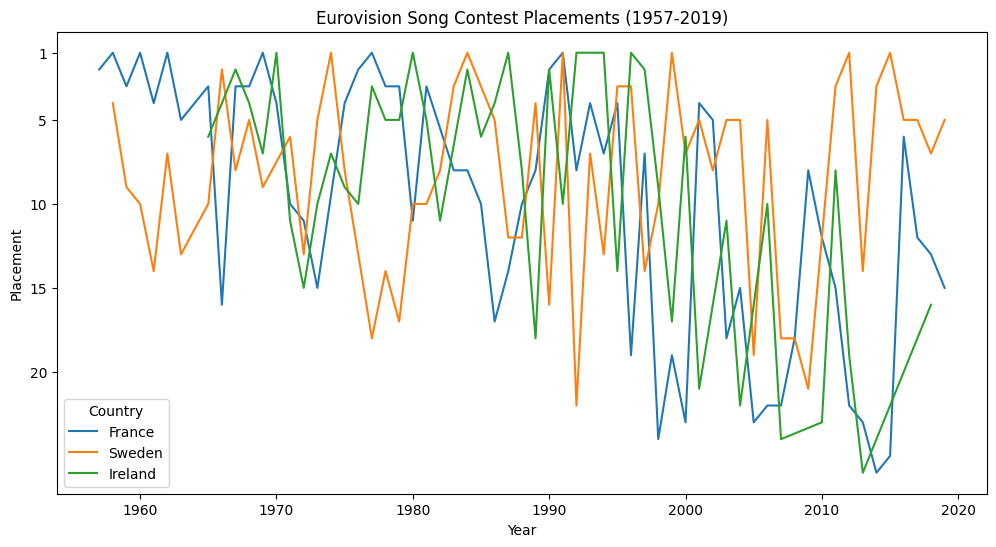

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

df = vote_summary_all[vote_summary_all["country"].isin(["Ireland", "Sweden", "France"])]

plt.figure(figsize=(12, 6))

sns.lineplot(x="year", y="place", hue="country", data=df)

plt.yticks([1, 5, 10, 15, 20])  # Show only the y-axis label "1"

plt.gca().invert_yaxis()  # This will invert the y-axis so that the top placement is at the top of the chart

plt.title("Eurovision Song Contest Placements (1957-2019)")

plt.ylabel("Placement")

plt.xlabel("Year")

plt.legend(title="Country")

plt.show()

This chart shows placements for France, Sweden and IReland over the years. It's a bit hard to read though. 



### Line Plot 2

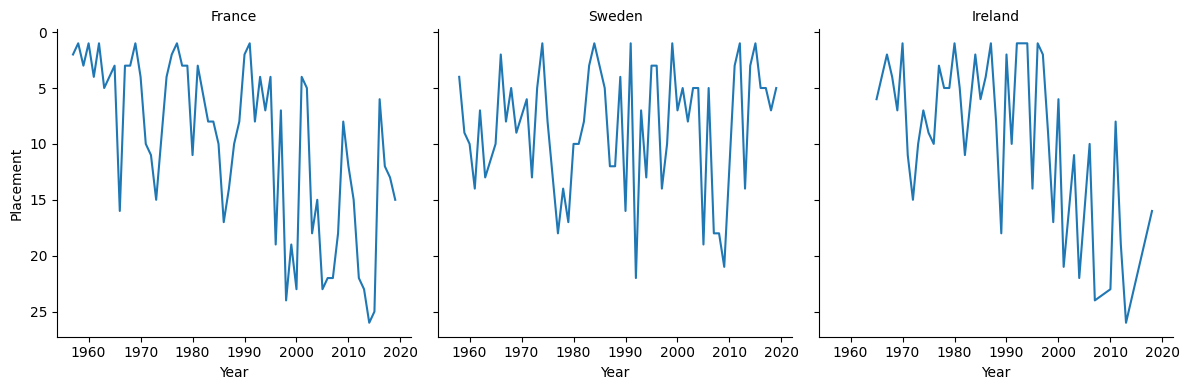

In [142]:
df = vote_summary_all[vote_summary_all["country"].isin(["Ireland", "Sweden", "France"])]

g = sns.FacetGrid(df, col="country", height=4, aspect=1)
g = g.map(plt.plot, "year", "place").set_titles("{col_name}").set_axis_labels("Year", "Placement")
plt.gca().invert_yaxis()

Having seperate line plots side by side doesn't really help

### Line Plot 3

Let's use a rolling 5 year average of placements, to see if that helps us observe a trend.

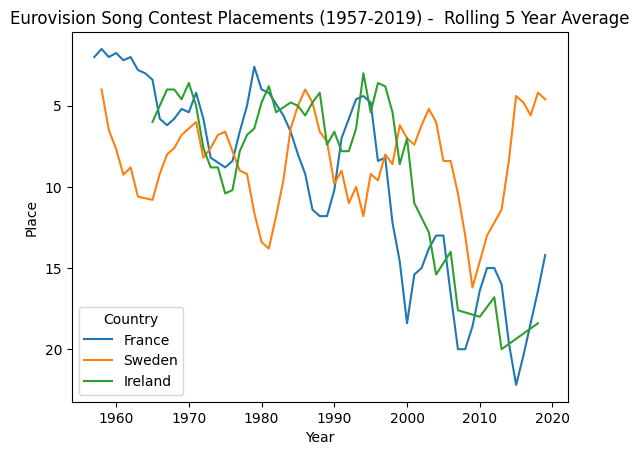

In [143]:
df = vote_summary_all[vote_summary_all["country"].isin(["Ireland", "Sweden", "France"])]

df["rolling_avg"] = df.groupby("country")["place"].transform(lambda x: x.rolling(5, 1).mean())

sns.lineplot(x="year", y="rolling_avg", hue="country", data=df)

plt.gca().invert_yaxis()

plt.title("Eurovision Song Contest Placements (1957-2019) -  Rolling 5 Year Average")

plt.ylabel("Place")

plt.xlabel("Year")

plt.legend(title="Country")

plt.show()

THis shows us that
- France trended better in the yearlier years of the competition
- Ireland did well better in the 1990s
- Sweden have been doesing better in the 2015 to 2020

### Scatter Plot

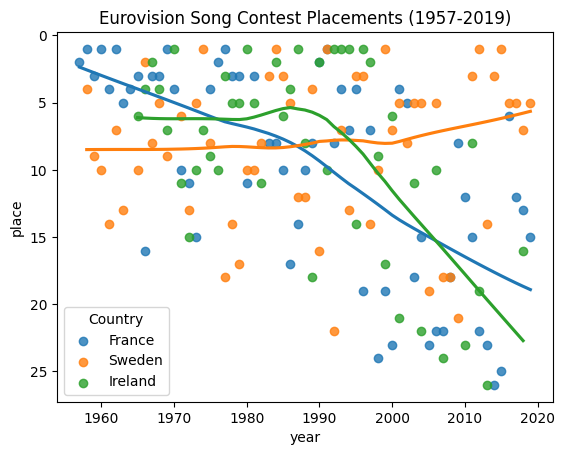

In [144]:
df = vote_summary_all[vote_summary_all["country"].isin(["Ireland", "Sweden", "France"])]

sns.regplot(x="year", y="place", data=df[df["country"] == "France"], lowess=True, label="France")
sns.regplot(x="year", y="place", data=df[df["country"] == "Sweden"], lowess=True, label="Sweden")
sns.regplot(x="year", y="place", data=df[df["country"] == "Ireland"], lowess=True, label="Ireland")

plt.title("Eurovision Song Contest Placements (1957-2019)")

plt.gca().invert_yaxis()
plt.legend(title="Country")
plt.show()

The scatter plot points are, again, a bit difficult to read, but the trend line reinforces what we saw above.

### Heat Map

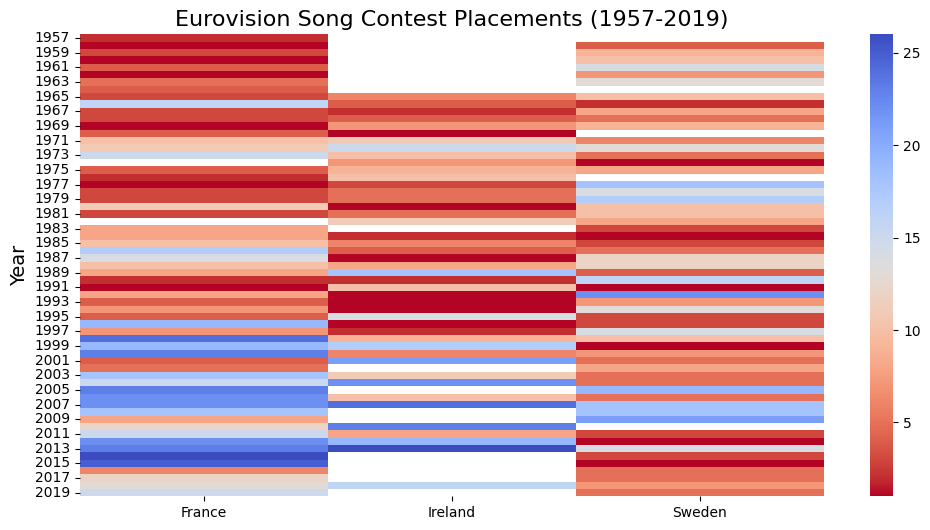

In [145]:
df = vote_summary_all[vote_summary_all["country"].isin(["Ireland", "Sweden", "France"])]
pivot_df = df.pivot_table(index="year", columns="country", values="place")

plt.figure(figsize=(12, 6))

sns.heatmap(pivot_df, cmap="coolwarm_r") # You can adjust the annotation size here

plt.title("Eurovision Song Contest Placements (1957-2019)", fontsize=16)
plt.ylabel("Year", fontsize=14)
plt.xlabel("", fontsize=14)
plt.show()

In this heat map, more red means higher placings! Blue is bad. 

This shows the trend a bit better. Sweden have been performing best lately. France or Ireland haven't been doing well at all since the early 2000s


## What countries performed better between 2005 and 2010?

The above charts neither France, Ireland or Sweden performed great between, roughtly, 2005 and 2010. 

What coutries did well in those years?

In [146]:
vote_summary_all[(vote_summary_all["place"] == 1) & (vote_summary_all["year"].isin([2006,2007,2008,2009,2010]))]["country"].value_counts().reset_index().head(5)

,country,count
0,Finland,1
1,Serbia,1
2,Russia,1
3,Norway,1
4,Germany,1


## What are the top 3 Countries appearing Most in Finals (Excluding Big 5)

In [147]:
vote_xbig5 = vote_summary_all[~vote_summary_all["country"].isin(["Germany", "Spain", "United Kingdom", "France", "Italy"])]
vote_xbig5["country"].value_counts().reset_index().head(10)

,country,count
0,Sweden,58
1,Norway,55
2,Netherlands,50
3,Belgium,50
4,Switzerland,48
5,Austria,47
6,Finland,45
7,Ireland,45
8,Denmark,44
9,Portugal,42


## What are the top 5 Coutries/Years watched on Youtube?

In [148]:
vote_summary_all[["year", "country", "performer", "song", "place", "view_count", "youtube_url"]].sort_values(by="view_count", ascending=False).head(5)

,year,country,performer,song,place,view_count,youtube_url
1048,2009,Turkey,Hadise,Düm Tek Tek,4,70022122.0,https://youtube.com/watch?v=wwFkWsr9yV4
1043,2009,Norway,Alexander Rybak,Fairytale,1,66258933.0,https://youtube.com/watch?v=WXwgZL4zx9o
1123,2012,Sweden,Loreen,Euphoria,1,60043617.0,https://youtube.com/watch?v=Pfo-8z86x80
958,2006,Finland,Lordi,Hard Rock Hallelujah,1,51582261.0,https://youtube.com/watch?v=gAh9NRGNhUU
1203,2015,Sweden,Måns Zelmerlöw,Heroes,1,51393370.0,https://youtube.com/watch?v=5sGOwFVUU0I


In [164]:
vote_summary_all

,year,country,total_points,place,performer,song,youtube_url,view_count,view_count_rank
0,1957,Austria,3,10,Bob Martin,"Wohin, Kleines Pony",https://youtube.com/watch?v=5mETWk_nB1Q,36104.0,5
1,1957,Belgium,5,8,Bobbejaan Schoepen,Straatdeuntje,https://youtube.com/watch?v=mu8ueVHTb9k,26925.0,6
2,1957,Switzerland,5,8,Lys Assia,L'enfant Que J'étais,https://youtube.com/watch?v=16ltDhw2lxs,15442.0,9
3,1957,Germany,8,4,Margot Hielscher,"Telefon, Telefon",https://youtube.com/watch?v=NoDpE2LtoZA,40373.0,3
4,1957,Denmark,10,3,Birthe Wilke & Gustav Winckler,Skibet Skal Sejle I Nat,https://youtube.com/watch?v=vX3WRMF5TuY,261651.0,2
...,...,...,...,...,...,...,...,...,...
1304,2019,Serbia,89,18,Nevena Božović,Kruna,https://youtube.com/watch?v=X0mdaeAyPvA,437304.0,37
1305,2019,Russia,370,3,Sergey Lazarev,Scream,https://youtube.com/watch?v=eNzlxEZ_JG4,7296296.0,5
1306,2019,Sweden,334,5,John Lundvik,Too Late for Love,https://youtube.com/watch?v=oEdWkdVKIqQ,3248626.0,13
1307,2019,Slovenia,105,15,Zala Kralj & Gašper Šantl,Sebi,https://youtube.com/watch?v=vGtPNQ6g6Ng,2659455.0,16


## Do coutries that win have the most youtube hits in each year?

Need to tidy up data a bit more. IN 1991 and 1969 we had countries finishing with equal points...

Remove countries except those with highest youtube views...

In [175]:
winners = vote_summary_all[vote_summary_all["place"] == 1]
winners.sort_values(["year", "view_count_rank"], inplace=True)
winners[winners["year"].isin([1991, 1969])]

,year,country,total_points,place,performer,song,youtube_url,view_count,view_count_rank
181,1969,Spain,18,1,Salomé,Vivo Cantando,https://youtube.com/watch?v=_-PVtGc59CI,1777363.0,1
184,1969,United Kingdom,18,1,Lulu,Boom Bang-a-bang,https://youtube.com/watch?v=4ew43u2gS0Y,1717353.0,2
189,1969,Netherlands,18,1,Lenny Kuhr,De Troubadour,https://youtube.com/watch?v=dsP3lhz5J30,31153.0,10
183,1969,France,18,1,Frida Boccara,"Un Jour, Un Enfant",https://youtube.com/watch?v=M02ylY1DTC4,NaN,999
611,1991,Sweden,146,1,Carola,Fångad Av En Stormvind,https://youtube.com/watch?v=7wnS4nu-bOc,1026807.0,1
600,1991,France,146,1,Amina,C'est Le Dernier Qui A Parlé Qui A Raison,https://youtube.com/watch?v=PnxEBAoCZIw,573856.0,2


In [176]:
winners.drop_duplicates(["year"], inplace=True)
winners[winners["year"].isin([1991, 1969])]

,year,country,total_points,place,performer,song,youtube_url,view_count,view_count_rank
181,1969,Spain,18,1,Salomé,Vivo Cantando,https://youtube.com/watch?v=_-PVtGc59CI,1777363.0,1
611,1991,Sweden,146,1,Carola,Fångad Av En Stormvind,https://youtube.com/watch?v=7wnS4nu-bOc,1026807.0,1


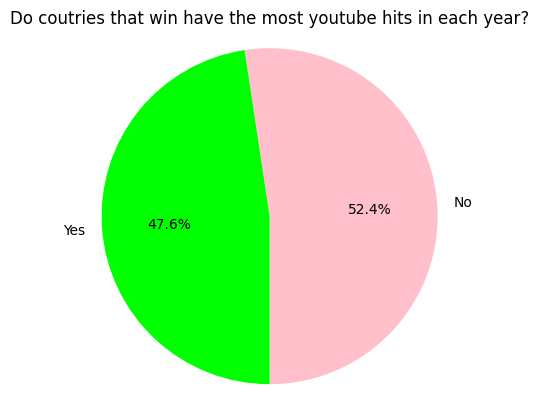

In [222]:
place_v_yt = winners["view_count_rank"] == 1
place_v_yt.replace({True: "Yes", False: "No"}, inplace=True)

counts = place_v_yt.value_counts()

colors = ["pink", "lime"]

plt.pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=-90, colors=colors)

plt.axis("equal")  # Equal aspect ratio ensures the pie chart is circular
plt.title("Do coutries that win have the most youtube hits in each year?")
plt.show()

It' s important to note that this is based on the youtube urls provided in the data.

Each song
- has a single youtube video in the provided dataset; and 
- many are from small youtube channells

In reality, songs will have many youtube videos from different channells. It would be better if we could aggregate view counts for these.
Altatnatively, we could just view counts from official Eurovision Youtube Channel. 

## Based on our data for each year, what countries win "youtube views"?

In [224]:
vote_summary_all[vote_summary_all["view_count_rank"] == 1]["country"].value_counts().reset_index().head(5)

,country,count
0,Spain,9
1,Sweden,7
2,Italy,5
3,Norway,4
4,Luxembourg,4


In [228]:
vote_summary_all[vote_summary_all["view_count_rank"] == 1]

,year,country,total_points,place,performer,song,youtube_url,view_count,view_count_rank
9,1957,Netherlands,31,1,Corry Brokken,Net Als Toen,https://youtube.com/watch?v=e5gLyP977ew,481385.0,1
16,1958,Italy,13,3,Domenico Modugno,Nel Blu Dipinto Di Blu,https://youtube.com/watch?v=6DTo5aVLq5E,115336.0,1
27,1959,Italy,9,6,Domenico Modugno,Piove,https://youtube.com/watch?v=n0enVNAU5sY,172813.0,1
42,1960,Norway,11,4,Nora Brockstedt,Voi-voi,https://youtube.com/watch?v=gvPieP0mys4,232731.0,1
49,1961,Spain,8,9,Conchita Bautista,Estando Contigo,https://youtube.com/watch?v=FAvnLCTvIwo,527940.0,1
...,...,...,...,...,...,...,...,...,...
1203,2015,Sweden,365,1,Måns Zelmerlöw,Heroes,https://youtube.com/watch?v=5sGOwFVUU0I,51393370.0,1
1228,2016,Russia,491,3,Sergey Lazarev,You Are the Only One,https://youtube.com/watch?v=e94dst20C9Y,48707678.0,1
1249,2017,Moldova,374,3,Sunstroke Project,Hey Mamma,https://youtube.com/watch?v=SWaQdHoCvYk,21203107.0,1
1272,2018,Israel,529,1,Netta Barzilai,Toy,https://youtube.com/watch?v=84LBjXaeKk4,50637340.0,1


## Are youtube view higher for more recent years?

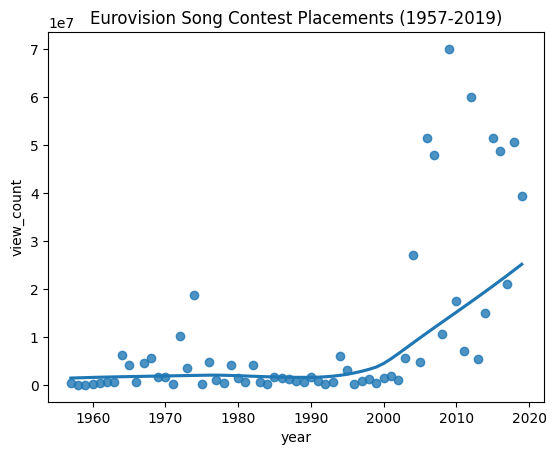

In [230]:
df = vote_summary_all[vote_summary_all["view_count_rank"] == 1]

sns.regplot(x="year", y="view_count", data=df, lowess=True, label="View Counts")

plt.title("Eurovision Song Contest Placements (1957-2019)")

plt.show()